In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import pickle
import joblib
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dropout,Dense,Input
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

/kaggle/input/birdfrog-eda/test_labels.pkl
/kaggle/input/birdfrog-eda/train_features.pkl
/kaggle/input/birdfrog-eda/filename-noise.wav
/kaggle/input/birdfrog-eda/filename.wav
/kaggle/input/birdfrog-eda/__results__.html
/kaggle/input/birdfrog-eda/train_labels.pkl
/kaggle/input/birdfrog-eda/test_features.pkl
/kaggle/input/birdfrog-eda/train_noOS_labels.pkl
/kaggle/input/birdfrog-eda/train_noOS_features.pkl
/kaggle/input/birdfrog-eda/__notebook__.ipynb
/kaggle/input/birdfrog-eda/__output__.json
/kaggle/input/birdfrog-eda/custom.css
/kaggle/input/birdfrog-eda/__results___files/__results___15_0.png
/kaggle/input/birdfrog-eda/__results___files/__results___25_0.png
/kaggle/input/birdfrog-eda/__results___files/__results___10_0.png
/kaggle/input/birdfrog-eda/__results___files/__results___19_0.png
/kaggle/input/birdfrog-eda/__results___files/__results___31_0.png
/kaggle/input/birdfrog-eda/__results___files/__results___27_0.png
/kaggle/input/birdfrog-eda/__results___files/__results___21_0.png
/ka

In [2]:
X_train = joblib.load('/kaggle/input/birdfrog-eda/train_features.pkl')
X_test = joblib.load('/kaggle/input/birdfrog-eda/test_features.pkl')
print(X_train.shape,X_test.shape)

(1226, 128, 1000, 3) (304, 128, 1000, 3)


In [3]:
y_train = np.array(joblib.load('/kaggle/input/birdfrog-eda/train_labels.pkl'))
y_test = np.array(joblib.load('/kaggle/input/birdfrog-eda/test_labels.pkl'))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape,X_val.shape, y_val.shape)

(919, 128, 1000, 3) (919,) (304, 128, 1000, 3) (304,) (307, 128, 1000, 3) (307,)


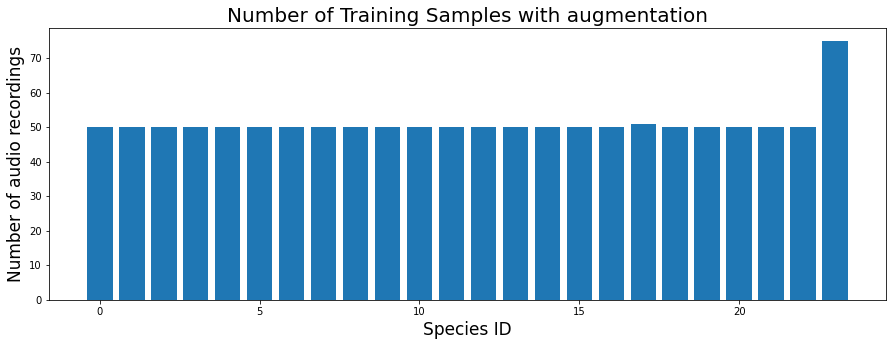

In [4]:
unique, counts = np.unique(np.concatenate((y_train,y_val)),return_counts=True)
values=dict(zip(unique,counts))
fig, ax = plt.subplots(figsize=(15,5))
barlist=plt.bar(values.keys(),values.values(), label='Minority samples')
plt.xlabel('Species ID', fontsize=17)
plt.ylabel('Number of audio recordings', fontsize=17)
plt.title('Number of Training Samples with augmentation', fontsize=20)
plt.show()

# Extract only the first dimension containing the spectral bandwidth, spectral centroid and the chroma temperature. These don't have a large spatial component to them, so the ANN is able to model these more than the other two dimensions. Including the other two dimensions results in an accuracy less than 10%.

In [5]:
X_train=X_train[:,:,:,0]
X_val=X_val[:,:,:,0]
X_test=X_test[:,:,:,0]

# ANN learns well until 50 epochs, after which it starts to overfit the training data.

In [6]:
ANNmodel = Sequential()
ANNmodel.add(layers.Dense(256, activation='relu', input_shape=(X_train.reshape(919,128*1000).shape[1],)))
ANNmodel.add(layers.Dense(128, activation='relu'))
ANNmodel.add(layers.Dropout(0.2))
ANNmodel.add(layers.Dense(128, activation='relu'))
ANNmodel.add(layers.Dense(64, activation='relu'))
ANNmodel.add(layers.Dropout(0.2))
ANNmodel.add(layers.Dense(64, activation='relu'))
ANNmodel.add(layers.Dense(32, activation='relu'))
ANNmodel.add(layers.Dropout(0.2))
ANNmodel.add(layers.Dense(24, activation='softmax'))
ANNmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
ANNmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               32768256  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4

In [7]:
ANNclassifier = ANNmodel.fit(X_train.reshape(919,128*1000),
                    y_train,
                    epochs=50, validation_data=(X_val.reshape(307,128*1000), 
                    y_val),
                    batch_size=919)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 3.1780 - accuracy: 0.0457 - val_loss: 3.1576 - val_accuracy: 0.0782
Epoch 2/50
1/1 [==============================] - 1s 647ms/step - loss: 3.1461 - accuracy: 0.0718 - val_loss: 3.1095 - val_accuracy: 0.0717
Epoch 3/50
1/1 [==============================] - 1s 504ms/step - loss: 3.1174 - accuracy: 0.0729 - val_loss: 3.0584 - val_accuracy: 0.0717
Epoch 4/50
1/1 [==============================] - 0s 453ms/step - loss: 3.0768 - accuracy: 0.0827 - val_loss: 2.9891 - val_accuracy: 0.1140
Epoch 5/50
1/1 [==============================] - 0s 474ms/step - loss: 3.0240 - accuracy: 0.1066 - val_loss: 2.9497 - val_accuracy: 0.1466
Epoch 6/50
1/1 [==============================] - 0s 445ms/step - loss: 2.9718 - accuracy: 0.1045 - val_loss: 2.8919 - val_accuracy: 0.1694
Epoch 7/50
1/1 [==============================] - 0s 454ms/step - loss: 2.9253 - accuracy: 0.1317 - val_loss: 2.8800 - val_accuracy: 0.1824
Epoch 8/50
1/1 [=======

In [8]:
TrainLoss, Trainacc = ANNmodel.evaluate(X_train.reshape(919,128*1000),y_train)
TestLoss, Testacc = ANNmodel.evaluate(X_test.reshape(304,128*1000), y_test)
y_pred=ANNmodel.predict(X_test.reshape(304,128*1000))
print('TrainLoss: %f, Train accuracy %f, TestLoss: %f, Test Accuracy: %f ' %(TrainLoss,Trainacc,TestLoss,Testacc))
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

10/10 [==============================] - 0s 9ms/step - loss: 0.4669 - accuracy: 0.9342
TrainLoss: 0.401309, Train accuracy 0.915125, TestLoss: 0.466916, Test Accuracy: 0.934211 
Confusion_matrix:  tf.Tensor(
[[10  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  2  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 13  0  0  

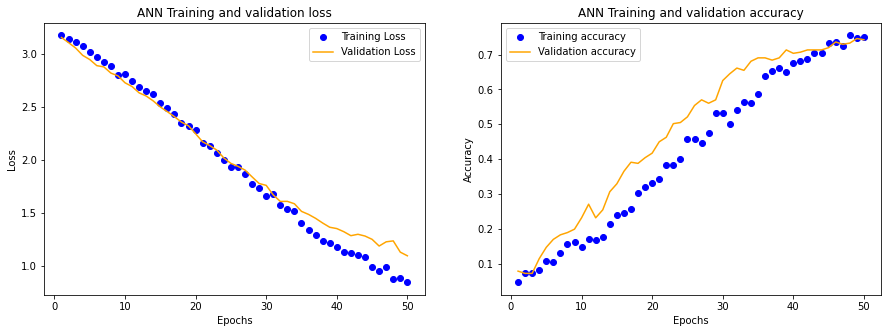

In [9]:
history_dict=ANNclassifier.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,51)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('ANN Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('ANN Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()